# Physical variables

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/gud_groups
conda env create -f binder/environment.yml
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

Once the environment gud_groups is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

# First, load libraries

In [1]:
import math
import matplotlib as mpl
import matplotlib.patches
import matplotlib.pyplot as plt
import netcdf_tools
import numpy as np
import pandas as pd
import os
import read_mitgcm
import scipy.interpolate
import statsmodels.nonparametric.smoothers_lowess
import tarfile
import vstats_pos

In [2]:
plt.close("all")

# Select year

In [3]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [4]:
gridfile='grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [5]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [6]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

# Observations

## Observations: sea ice concentration

The values of observed sea ice concentrations were boolean values of 0
and 1 because sea ice melted suddenly in only one day.
Here, these values were retrieved from the file of the forcing fields
of sea ice concentration.
We made sure these values corresponded to the expected values.

In [7]:
infile_sic=\
'../../gud_1d_35+16/input_noradtrans/input/siarea.qik.2016.365.32bits.bin'
array1d_iT_sic=np.fromfile(infile_sic,dtype='>f')

Sea ice break-up was on 18 July 2016, doy (0-based)=199.

In [8]:
obs_breakup=next(i for i,v in list(enumerate(array1d_iT_sic)) if v==0)

assert obs_breakup==199,\
'the day of year (0-based) of break-up from the file %s (obs_breakup=%r)'\
' is different from the day of year of break-up'\
' from Oziel et al., 2019 in Elem. Sci. Anth. (July 18=199).'\
% (infile_sic,obs_breakup)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Green Edge sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness ($cm$).

### Observations: snow and ice thickness: load dataset

In [9]:
def load_thickness():
    fname='../../obs/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [10]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [11]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]
# snow_thickness_df[['date','sample_thickness_m_average']]

The start of the period without observed snow cover was defined as the
start of the melt pond period.
It was on 15 June 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [12]:
obs_nosnow=166 # 0-based

We select the observations of ice thickness at the ice camp 2016.

In [13]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: mixing layer

The depth of the mixing layer was 25 m on June 23, 2016
(Oziel et al., 2019, in $Elem\ Sci\ Anth$).

In [14]:
obsKz=25
obsKz_date=174

## Observations: equivalent mixed layer depth

In m.

The equivalent mixed layer depth was calculated with the method of
Randelhoff et al. (2017) in $J\ Phys\ Ocean$.
doi:10.1175/JPO-D-16-0200.1.

The observations are plotted in the Figure 10 of 
Oziel et al., 2019, in $Elem\ Sci\ Anth$.
The values are from the file PARAMETERS_ZEU_HBD_TCHLA_FOR_LEO_2016.mat that Leo Lacour sent me on August 19, 2020.
The variable HBD was processed with my private project
https://github.com/maximebenoitgagne/hBD to smooth the values with the
parameter med=7.

In [15]:
def load_hBD(fname):
    df1 = (
        pd.read_csv(
            fname,
            dtype={
                'doy_1based': np.int32,
                'hBD_m': np.float32
            },
        )
        .rename(
            columns=dict(
                hBD_m='hBD'
            )
        )
    )
    df1['doy']=df1['doy_1based'].apply(lambda x:x-1) # 0-based
    df2=pd.DataFrame(df1[['doy','hBD']])
    return df2

In [16]:
infile_hBD='../../obs/hBD.csv'
hBD_df=load_hBD(infile_hBD)

## Observations: PAR

In $\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

Conversion factor from
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$
to
$\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

In [17]:
uEs2Ed=1E-6*86400

The file C-OPS from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ underwater PAR at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'averaged_par_d_fit_daily_ein_m_2_day_1' is the downwelling PAR (mol photons $\mathrm{ m^{-2} }$ $\mathrm{ d^{-1} }$).

Let $\mathrm{ I_i }$ the PAR just below sea ice.

PAR just below surface ($\mathrm{ 0^- }$) was observed only just
below sea ice ($\mathrm{ I_i }$).
PAR just below surface ($\mathrm{ 0^- }$) was not observed just
below open water ($\mathrm{ I_w }$).
Observed PAR ($\mathrm{ 0^- }$) was thus equivalent to 
observed PAR just below sea ice ($\mathrm{ I_i })$.

### Observations: PAR: load dataset

In [18]:
def load_par(fname):
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [19]:
infile_PAR_iceFile='../../obs/66399.csv'
par_df=load_par(infile_PAR_iceFile)

### Observations: PAR: select

In [20]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [21]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [22]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

The first value of simulated PAR had a depth=0 m even when there was sea ice. The first value of observed PAR had a depth equals to the thickness of sea ice in the water. For example, if there was 1 m of sea ice in the water, the first value of observed PAR would be at depth=1 m. We changed that for a depth=0 m to be coherent with the simulated values. Indeed, we wanted to compare observed and simulated PAR at the same distance from the bottom of sea ice and not at the same distance from the water surface.

In [23]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=parwater_df.loc[(parwater_df.doy==doy),('depth')].min() # m
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']-ice_thickness

In [24]:
# mol photons m^-2 d^-1
array1d_iT_obsPAR0m=np.empty(365)
array1d_iT_obsPAR0m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    array1d_iT_obsPAR0m[doy-1]=\
    parwater_df.loc[(parwater_df.doy==doy) & (parwater_df.depth==0),
                    'par']

The first observation of PAR under sea ice was on 4 May,
doy (0-based)=124.

In [25]:
first_obs_PAR=np.where(~np.isnan(array1d_iT_obsPAR0m))[0][0]
first_obs_PAR
assert first_obs_PAR==124,\
'the day of year (0-based) of the first observation of PAR under sea ice'\
' from the file %s (first_obs_PAR=%r)'\
' is different from the expected value of 124 (May 4).'\
% (infile_PAR_iceFile,first_obs_PAR)

### Observations: PAR: depth of the $\mathrm{ z_{0.415} }$ isolume

In [26]:
array1d_iT_obsisolume=np.empty(365)
array1d_iT_obsisolume[:]=np.NaN
c_isolume=0.415 # mol photons m^-2 d^-1
for doy in pd.unique(parwater_df['doy']):
    parwater_onedoy_df=parwater_df[parwater_df.doy==doy]
    if parwater_onedoy_df.iloc[0,:]['par'] > c_isolume:
        idx_isolume=vstats_pos.find_idx_nearest \
        (array=parwater_onedoy_df['par'],
         value=c_isolume)
        isolume=parwater_onedoy_df['depth'].iloc[idx_isolume]
        array1d_iT_obsisolume[doy-1]=isolume

In [27]:
# for i,v in enumerate(array1d_iT_obsisolume):
#     print(i,v)

In [28]:
array1d_iobs_doy\
=np.argwhere(np.logical_not(np.isnan(array1d_iT_obsisolume))).flatten()
array1d_iobs_obsisolume=array1d_iT_obsisolume[array1d_iobs_doy].flatten()
f=scipy.interpolate.interp1d(array1d_iobs_doy, array1d_iobs_obsisolume)
array1d_idomain_obsisolume_domain=np.arange(array1d_iobs_doy[0],
                                            array1d_iobs_doy[-1]+1)
array1d_idomain_obsisolume_interp=f(array1d_idomain_obsisolume_domain)
start=np.empty(array1d_iobs_doy[0])
start[:]=np.nan
end  =np.empty(365-1-array1d_iobs_doy[-1])
end  [:]=np.nan
array1d_iT_obsisolume_interp\
=np.concatenate((start,
                 array1d_idomain_obsisolume_interp,
                 end),
                axis=0)

In [29]:
# for i,v in enumerate(array1d_iT_obsisolume_interp):
#     print(i,v)

# Model NEMO-LIM3

## Model NEMO-LIM3: sea ice concentration

In [30]:
infile_sim_sic='../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin'
sim_sic=np.fromfile(infile_sim_sic,dtype='>f')
# for i,v in enumerate(ice):
#     print(i,v)

## Model NEMO-LIM3: snow and ice thickness

Snow volume is the weighted average of snow thickness averaged by the sea ice concentration. For example, if there is $50\%$ of sea ice concentration and $2\ m$ of snow on the sea ice-covered part of the pixel, snow volume will be $1\ m$. The expression 'snow thickness' in the labels of the plots corresponds to the variable 'snow volume' in NEMO-LIM3 and the NetCDF file Ice_d.nc.

Variable 'snow volume' is the snow volume ($m$).
It is at indices (1,1) meaning centre of grid point was used.
File 'Ice_d.nc' is the output of NEMO3.6+LIM3.6 configured by Gaetan Olivier (UBO) for the Green Edge ice camp 2016 ($67.48^\circ N$, $-63.79^\circ E$).

### Model NEMO-LIM3: snow and ice thickness: snow

Form 2013 to 2017.

In [31]:
ice_file='../../gud_1d_35+16/input_noradtrans/input/Ice_d.nc'

In [32]:
array1d_iT_snow_volumefull=\
netcdf_tools.read_netcdf(ice_file,'snow volume')
array1d_iT_snow_volumefull=array1d_iT_snow_volumefull[:,1,1]

In 2016.

In [33]:
array1d_iT_snow_volume=array1d_iT_snow_volumefull[365*3:365*4]

The start of the period without simulated snow cover was defined as
the first day with less than 0.01 m of simulated snow.
It was on 20 June 2016, doy (0-based)=171.

In [34]:
# for i,v in enumerate(array1d_iT_snow_volume):
#     print(i,v)

In [35]:
sim_nosnow=np.where(array1d_iT_snow_volume<0.01)[0][0]
sim_nosnow
assert sim_nosnow==171,\
'the day of year (0-based) of the first simulation of absence of snow'\
' (sim_nosnow=%r)'\
' is different from the expected value of 171 (June 20).'\
% (sim_nosnow)

### Model NEMO-LIM3: snow and ice thickness: ice

Ice volume is the weighted average of ice thickness averaged by the sea ice concentration. For example, if there is $50\%$ of sea ice concentration and $2\ m$ of ice on the sea ice-covered part of the pixel, ice volume will be $1\ m$. The expression 'ice thickness' in the labels of the plots corresponds to the variable 'ice volume' in NEMO-LIM3 and the NetCDF file Ice_d.nc.

Variable 'ice volume' is the ice volume ($m$).
It is at indices (1,1) meaning centre of grid point was used.
File 'Ice_d.nc' is the output of NEMO3.6+LIM3.6 configured by Gaetan Olivier (UBO) for the Green Edge ice camp 2016 ($67.48^\circ N$, $-63.79^\circ E$).

From 2013 to 2017.

In [36]:
array1d_iT_ice_volumefull=\
netcdf_tools.read_netcdf(ice_file,'ice volume')
array1d_iT_ice_volumefull=array1d_iT_ice_volumefull[:,1,1]

In 2016.

In [37]:
array1d_iT_ice_volume=array1d_iT_ice_volumefull[365*3:365*4]

## Model NEMO-LIM3: temperature

In [38]:
tavefile='tave.0000000000.t001.nc'
array2d_idepth_iT_Ttavefull=netcdf_tools.read_netcdf(tavefile,'Ttave').squeeze().transpose()
array2d_idepth_iT_Ttavefull[-1,:]=np.nan
array2d_idepth_iT_Ttave=array2d_idepth_iT_Ttavefull[:,array1d_iT1y_iT]

## Model NEMO-LIM3: salinity

In [39]:
tavefile='tave.0000000000.t001.nc'
array2d_idepth_iT_Stavefull=netcdf_tools.read_netcdf(tavefile,'Stave').squeeze().transpose()
array2d_idepth_iT_Stavefull[-1,:]=np.nan
array2d_idepth_iT_Stave=array2d_idepth_iT_Stavefull[:,array1d_iT1y_iT]

### Model NEMO-LIM3: salinity: depth of isohaline 32.2

In [40]:
c_isohaline=32.2 # g kg^-1
(ndepths,ndays)=array2d_idepth_iT_Stave.shape
array1d_iT_modisohaline=np.empty(ndays)
array1d_iT_modisohaline[:]=np.NaN
for iT in first_year:
    array1d_idepth_Stave=array2d_idepth_iT_Stave[:,iT]
    if array1d_idepth_Stave[0]<c_isohaline:
        idx_isohaline\
        =vstats_pos.find_idx_nearest(array=array1d_idepth_Stave,
                                     value=c_isohaline)
        isohaline=RC[idx_isohaline]
        array1d_iT_modisohaline[iT]=isohaline

# Model NEMO-LIM3: vertical turbulent diffusivity ($\mathrm{K_z}$)

In $\mathrm{ m^2\ s^{-1} }$.

In [41]:
indir='../../gud_1d_35+16/input_noradtrans/input/NEMO_GE_2016'
if not os.path.isdir(indir):
    tar=tarfile.open(indir+'.tar')
    tar.extractall(path=os.path.dirname(indir))
    tar.close()
YYYY=2016
ndays=first_year.size
ndepths=RC.size
array2d_idepth_iT_Kz=np.empty((ndepths,ndays))
array2d_idepth_iT_Kz[:,:]=np.NaN
for iT in first_year:
    timestamp=(YYYY-1979)*ndays*36+(iT+1)*36
    Kzfile=os.path.join(indir,
                       'KPPdiffS.'+str(timestamp).zfill(10)+'.data')
    array1d_iT_Kz=np.fromfile(Kzfile,dtype='>f')
    array2d_idepth_iT_Kz[:,iT]=array1d_iT_Kz

In [42]:
depth_Kzmin=2
depth_Kzmax=350

### Model NEMO-LIM3: vertical turbulent diffusivity ($\mathrm{K_z}$): $\mathrm{ K_z=10^{-4}\ m^2\ s^{-1} }$

Depth with a $\mathrm{ K_z =10^{-4} }$.
In m.
This depth is relevant for the period of complete or partial sea ice
cover.

In [43]:
c_isoKz1=1E-4 # m^2 s^-1
(ndepths,ndays)=array2d_idepth_iT_Stave.shape
array1d_iT_modisoKz1=np.empty(ndays)
array1d_iT_modisoKz1[:]=np.NaN
for iT in first_year:
    array1d_idepth_Kz=array2d_idepth_iT_Kz[:,iT]
    idx_isoKz1\
    =vstats_pos.find_idx_nearest(array=array1d_idepth_Kz,
                                 value=c_isoKz1)
    isoKz1=RC[idx_isoKz1]
    array1d_iT_modisoKz1[iT]=isoKz1
mask=(array1d_iT_modisoKz1<depth_Kzmin) \
| (array1d_iT_modisoKz1>depth_Kzmax)
array1d_iT_modisoKz1[mask]=np.NaN

In [44]:
# for i,v in enumerate(array1d_iT_modisoKz1):
#     print(i,v)

LOWESS.

In [45]:
x=first_year
y=array1d_iT_modisoKz1
# frac=2/3 is the default
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/15)
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points
# and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False)
# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
# Find y values based on the interpolation method
array1d_iT_modisoKz1lowess=f_linear(xnew)
# Construct the array of length 365
start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_modisoKz1lowess=np.concatenate((start_edge,
                                           array1d_iT_modisoKz1lowess,
                                           end_edge))

# Model MITgcm

In [46]:
carfile='car.0000000000.t001.nc'

## Model MITgcm: depth of the $\mathrm{ 0.415\ mol\ photons\ m^{-2}\ d^{-1} }$ isolume

In m.

In [47]:
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARfullumolEonm2s\
=netcdf_tools.read_netcdf(carfile,'PAR').squeeze().transpose()
if np.all(array2d_idepth_iT_PARfullumolEonm2s==0):
    #define GUD_PARUICE
    array2d_idepth_iT_PAR_icefullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ice').squeeze().transpose()
    array2d_idepth_iT_PAR_icefull\
    =array2d_idepth_iT_PAR_icefullumolEonm2s*1e-6*stod
    array2d_idepth_iT_PAR_owfullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ow').squeeze().transpose()
    array2d_idepth_iT_PAR_owfull\
    =array2d_idepth_iT_PAR_owfullumolEonm2s*1e-6*stod
    (ndepths,ndays)=array2d_idepth_iT_PAR_icefull.shape
    array2d_idepth_iT_icefull\
    =np.tile(array1d_iT_sic,(ndepths,ndays//365))
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PAR_owfull*(1-array2d_idepth_iT_icefull)\
    +array2d_idepth_iT_PAR_icefull*array2d_idepth_iT_icefull
else:
    #undef GUD_PARUICE
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PARfullumolEonm2s*1e-6*stod
array2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPARfull[:,array1d_iT1y_iT]

In [48]:
c_isolume=0.415 # mol photons m^-2 d^-1
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modisolume=np.empty(ndays)
array1d_iT_modisolume[:]=np.NaN
for iT in first_year:
    array1d_idepth_meanPAR=array2d_idepth_iT_meanPAR[:,iT]
    if array1d_idepth_meanPAR[0]>c_isolume:
        idx_isolume=vstats_pos.find_idx_nearest(array=array1d_idepth_meanPAR,
                                                value=c_isolume)
        isolume=RC[idx_isolume]
        array1d_iT_modisolume[iT]=isolume

# Forcing fields

## Forcing field: sea ice concentration

In [49]:
infile_sicFile='../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin'
array1d_iT_forsic=np.fromfile(infile_sicFile,dtype='>f4')

The simulated sea ice break-up was on 20 July, doy (0-based)=201.

In [50]:
sim_breakup\
=next(i for i,v in list(enumerate(array1d_iT_forsic)) if v < 0.50)

In [51]:
sim_breakup

201

The simulated sea ice freeze-up was on 24 November, doy (0-based)=328.

In [52]:
sim_freezeup\
=next(i for i,v in reversed(list(enumerate(array1d_iT_forsic))) if v < 0.50)

In [53]:
sim_freezeup

328

## Forcing field: PAR just below surface ($\mathrm{ 0^- }$)

The first observation of PAR under sea ice in the forcing fields 
was on 4 May, doy (0-based)=124.

In [54]:
infile_PAR_iceFile='../../gud_1d_35+16/input_noradtrans/input/1D_obs_PARice_EXP0_y2016.365.32bits.bin'
array1d_iT_forPAR0m=np.fromfile(infile_PAR_iceFile,dtype='>f4')
first_for_PAR=np.where(array1d_iT_forPAR0m!=0)[0][0]
first_for_PAR
assert first_for_PAR==124,\
'the day of year (0-based) of the first observation of PAR under sea ice'\
' from the file %s (first_for_PAR=%r)'\
' is different from the expected value of 124 (May 4).'\
% (infile_PAR_iceFile,first_for_PAR)

In [55]:
# for i,v in enumerate(array1d_iT_forPAR0m):
#     print(i,v)

In [56]:
first_for_PAR

124

# Plot

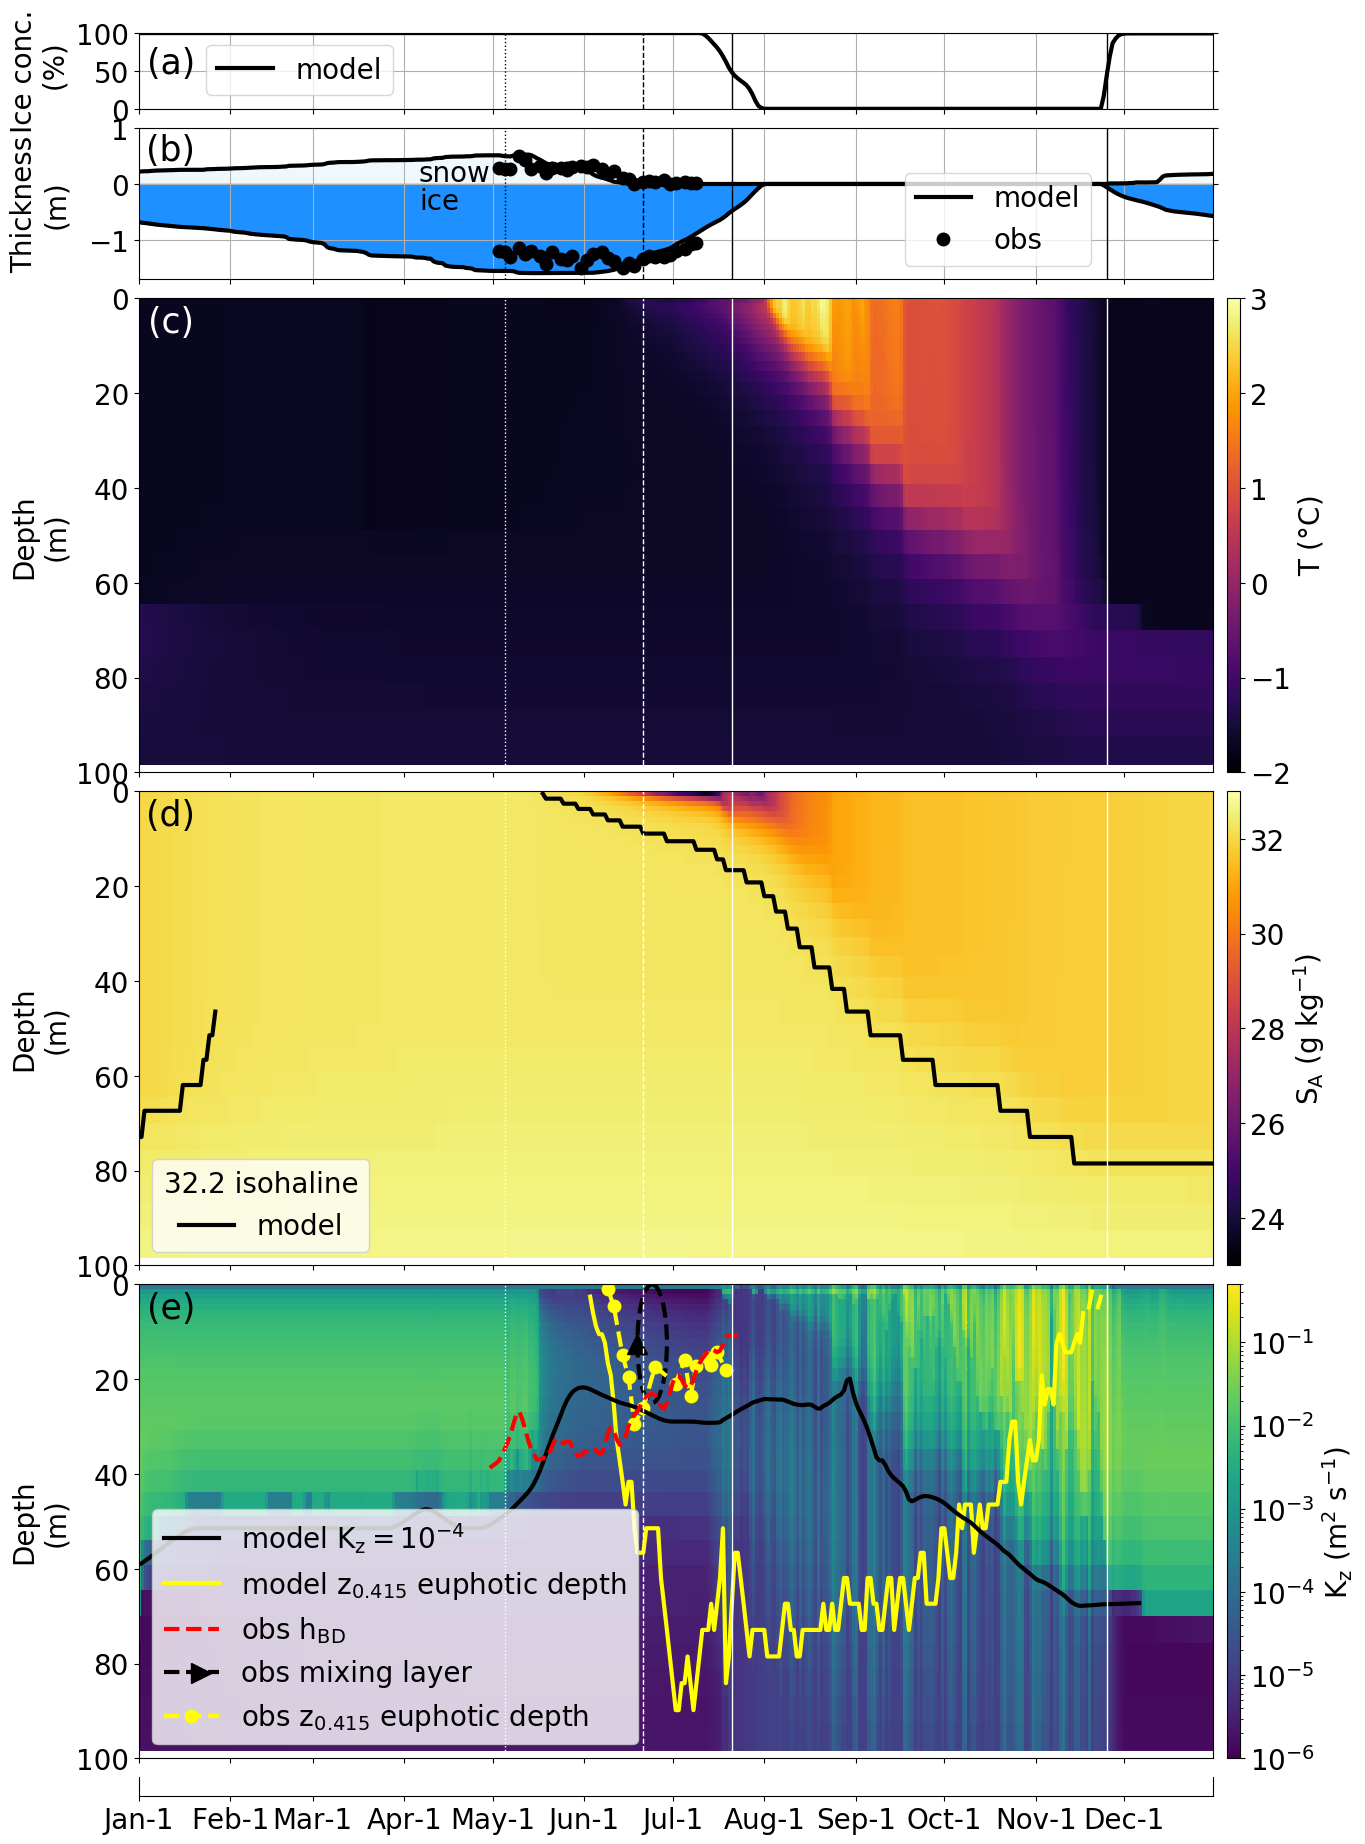

In [57]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ymin=0
    ymax=100
#     rect=mpl.patches.Rectangle(xy=(xmin,ymin),
#                                width=obs_breakup,height=ymax-ymin,
#                                linewidth=0,facecolor='grey',alpha=0.25)
#     ax.add_patch(rect)
#     rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
#                                width=364-sim_freezeup,height=ymax-ymin,
#                                linewidth=0,facecolor='grey',alpha=0.25)
#     ax.add_patch(rect)
    h1=ax.plot(first_year,sim_sic*100,
               color='black',linestyle='-',label='model')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)',bbox=box)
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.05,0.00))
    plt.text(0.03,0.6,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
#     ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
#     ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
#     ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')
    ax.axvline(first_for_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(sim_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(sim_breakup,color='black',linewidth=1,linestyle='-')
    ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')

    # --- SNOW AND ICE THICKNESS
    ax=axs[1]
    ymin=-1.7
    ymax=1.0
#     rect=mpl.patches.Rectangle(xy=(xmin,ymin),
#                                width=obs_breakup,height=ymax-ymin,
#                                linewidth=0,facecolor='grey',alpha=0.25)
#     ax.add_patch(rect)
#     rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
#                                width=364-sim_freezeup,height=ymax-ymin,
#                                linewidth=0,facecolor='grey',alpha=0.25)
#     ax.add_patch(rect)
    h1=ax.fill_between(first_year,array1d_iT_snow_volume,
                       linestyle='-',color='aliceblue',linewidth=1)
    h2=ax.plot(first_year,array1d_iT_snow_volume,
               linestyle='-',color='black',lw=3)
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    h4=ax.fill_between(first_year,-array1d_iT_ice_volume,
                       linestyle='-',color='dodgerblue',linewidth=1)
    h5=ax.plot(first_year,-array1d_iT_ice_volume,
               linestyle='-',color='black',lw=3)
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h6=ax.plot(xice,yice,'o',color='black')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    ax.legend([h2[0],h3[0]],['model','obs'],loc='lower left',
              bbox_to_anchor=(0.70,0.00))
    plt.text(0.03,0.85,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
#     ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
#     ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
#     ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')
    ax.axvline(first_for_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(sim_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(sim_breakup,color='black',linewidth=1,linestyle='-')
    ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')
    
    # --- TEMPERATURE
    ax=axs[2]
    RF_above100=RF[RF<100]
    h=ax.pcolormesh(first_year366,
                    RF_above100,
                    array2d_idepth_iT_Ttave[0:(RF_above100.size)-1,:],
                    cmap='inferno',
                    vmin=-2,
                    vmax=3)
    ax.set_xticklabels([])
    ax.set_ylabel('Depth\n(m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    cbaxes = fig.add_axes([0.90, 0.57, 0.01, 0.25])
    cbar=plt.colorbar(h,cax = cbaxes)
    cbar.set_label('T ($\degree$C)')
    plt.text(0.03,0.95,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='white', fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
#     ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
#     ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
#     ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')
    ax.axvline(first_for_PAR,color='white',linewidth=1,linestyle=':')
    ax.axvline(sim_nosnow,color='white',linewidth=1,linestyle='--')
    ax.axvline(sim_breakup,color='white',linewidth=1,linestyle='-')
    ax.axvline(sim_freezeup,color='white',linewidth=1,linestyle='-')
    
    # --- SALINITY
    ax=axs[3]
    RF_above100=RF[RF<100]
    h=ax.pcolormesh(first_year366,
                    RF_above100,
                    array2d_idepth_iT_Stave[0:(RF_above100.size)-1,:],
                    cmap='inferno',
                    vmin=23,
                    vmax=33)
    ax.plot(first_year,array1d_iT_modisohaline,
           color='black',label='model')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth\n(m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.legend(loc='lower left',title='32.2 isohaline')
    cbaxes = fig.add_axes([0.90, 0.31, 0.01, 0.25])
    cbar=plt.colorbar(h,cax = cbaxes)
    cbar.set_label('$\mathrm{ S_A }$ ($\mathrm{ g\ kg^{-1} }$)')
    plt.text(0.03,0.95,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='black', fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
#     ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
#     ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
#     ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')
    ax.axvline(first_for_PAR,color='white',linewidth=1,linestyle=':')
    ax.axvline(sim_nosnow,color='white',linewidth=1,linestyle='--')
    ax.axvline(sim_breakup,color='white',linewidth=1,linestyle='-')
    ax.axvline(sim_freezeup,color='white',linewidth=1,linestyle='-')
    
    # --- VERTICAL TURBULENT DIFFUSIVITY
    ax=axs[4]
    RF_above100=RF[RF<100]
    
    # model Kz
    h=ax.pcolormesh(first_year366,
                    RF_above100,
                    array2d_idepth_iT_Kz[0:(RF_above100.size)-1,:],
                    cmap='viridis',
                    norm=mpl.colors.LogNorm(vmin=1E-6, vmax=0.5))
    
    # observed z_0415 euphotic depth
    h5=ax.plot(first_year,array1d_iT_obsisolume,
           'o',linewidth=3,color='yellow',linestyle='--',
           label='obs $\mathrm{ z_{0.415} }$ euphotic depth')
    ax.plot(first_year,array1d_iT_obsisolume_interp,
           linewidth=3,color='yellow',linestyle='--')
    
    # simulated z_0415 euphotic depth
    h2=ax.plot(first_year,array1d_iT_modisolume,
           linewidth=3,color='yellow',linestyle='-',
           label='model $\mathrm{ z_{0.415} }$ euphotic depth')
    
    # model Kz=10^-4
#     h1=ax.plot(first_year,array1d_iT_modisoKz1,
#             color='black',
#             label='model $\mathrm{ K_z=10^{-4} } $')
    h1=ax.plot(first_year,array1d_iT_modisoKz1lowess,
            color='black',
            label='model $\mathrm{ K_z=10^{-4} } $')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth\n(m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    cbaxes = fig.add_axes([0.90, 0.05, 0.01, 0.25])
    cbar=plt.colorbar(h,cax = cbaxes)
    cbar.set_label('$\mathrm{ K_z }$ ($\mathrm{ m^2\ s^{-1} }$)')
    
    # observed mixing layer
    xy=obsKz_date,obsKz/2
    width,height=10,obsKz
    ellipse=mpl.patches.Ellipse(xy=xy,width=width,height=height,
                                fill=False,
                                linewidth=3,color='black',linestyle='--')
    ax.add_patch(ellipse)
    ax.plot(obsKz_date-width/2,obsKz/2,
            '^',color='black',markersize=15)
    h4=ax.plot(0,0,
            linewidth=3,color='black',linestyle='--',
            label='obs mixing layer')
    
    # observed hBD
    h3=ax.plot(np.array(hBD_df.doy),np.array(hBD_df.hBD),
            color='red',linestyle='--',
            label='obs $\mathrm{ h_{BD} }$')
    
    lns=h1+h2+h3+h4+h5
    labs = [l.get_label() for l in lns]
    legend=ax.legend(lns,labs,loc='lower left')
    legend.set_zorder(3)
    ax.plot(21,82,'>',color='black',markersize=15,zorder=4)
    plt.text(0.03,0.95,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='black', fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
#     ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
#     ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
#     ax.axvline(sim_freezeup,color='black',linewidth=1,linestyle='-')
    ax.axvline(first_for_PAR,color='white',linewidth=1,linestyle=':')
    ax.axvline(sim_nosnow,color='white',linewidth=1,linestyle='--')
    ax.axvline(sim_breakup,color='white',linewidth=1,linestyle='-')
    ax.axvline(sim_freezeup,color='white',linewidth=1,linestyle='-')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[5]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.10,0.92  ,0.79,0.04])
    axs[1].set_position( [0.10,0.83  ,0.79,0.08])
    axs[2].set_position( [0.10,0.57  ,0.79,0.25])
    axs[3].set_position( [0.10,0.31  ,0.79,0.25])
    axs[4].set_position( [0.10,0.05  ,0.79,0.25])
    axs[5].set_position( [0.10,0.03  ,0.79,0.01])

with plt.style.context('physical.mplstyle'):
    # Plot
    fig,axs=plt.subplots(6,1,figsize=(13.6,18.96))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='physical.png'
    plt.savefig(outfile)

Figure \<physical\>. Some physical variables.
(a) Ice concentration from NEMO-LIM3.
(b) Snow and ice thickness.
    Lines are model snow and ice thickness from NEMO-LIM3.
    Dots are $in\ situ$ observations.
(c) Potential temperature from NEMO-LIM3.
(d) Absolute salinity from NEMO-LIM3.
    The simulated 32.2 isohaline is the black line.
(e) Vertical turbulent diffusivity ($\mathrm{ K_z }$).
    The depth at which simulated $\mathrm{ K_z=10^{-4}\ m^2\ s^{-1} }$
    is the black complete line.
    This line was smoothed with a locally weighted scatterplot
    smoothing (LOWESS).
    The depth of the simulated
    $\mathrm{ z_{0.415}\ mol\ photons\ m^{-2}\ d^{-1} }$
    isolume is the yellow complete line.
    The depth of the observed equivalent mixed layer
    ($\mathrm{ h_{BD} }$)
    $sensu$ Randelhoff et al. (2017) in $J\ Phys\ Ocean$
    is the red dashed line.
    The depth of the mixing layer measured on June 23, 2016
    as described in Oziel et al. (2019) in $Elem\ Sci\ Anth$
    is the black dashed arrow.
    The depth of the observed
    $\mathrm{z_{0.415}\ mol\ photons\ m^{-2}\ d^{-1} }$
    isolume is the yellow dashed line.
    The vertical lines represent chronologically the date of the first
    PAR observations, simulated snow melt completion, simulated break-up,
    and simulated freeze-up.